In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, balanced_accuracy_score, \
                            confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.extmath import density
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

from time import time

sns.set()
%matplotlib inline

# Загрузка данных

In [2]:
gb_data = pd.read_csv("Датасет GB.csv")
gb_data.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id
0,4358a11f0d16be6e,0,0,1,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,NaN,NaN,0,39,1,1,0
1,133509b7ff9a586c,0,0,0,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,-1,2,0,0
2,8b23cd36f2b08dcd,0,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,NaN,NaN,1,49,1,1,1
3,50de4c060fd128f3,0,1,1,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,NaN,NaN,-1,-1,1,1,0
4,c2ca3cc9a67c749b,0,0,0,2021-12-01,NaN,https://gb.ru/login,NaN,NaN,0,23,2,1,0


In [3]:
fields_description = pd.read_excel("Описание полей.xlsx", sheet_name='Лист1')
fields_description

,Поле,Описание
0,session_id,идентификатор сессии
1,claim,признак наличия отправки формы заявки во вемя ...
2,60sec,признак длительности сессии 60 секунд и более ...
3,scroll_90,признак вертикальной прокрутки страницы глубин...
4,hit_date,дата сессии
5,referer_url,адрес реферера страницы просмотра
6,url,адрес страницы просмотра
7,utm_source,utm-метка источника
8,utm_medium,utm-метка канала
9,gender,"пол посетителя из куки (-1 – не определен, 0 –..."


# Разведочный анализ данных (EDA)

In [4]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_id    884407 non-null  object
 1   claim         884407 non-null  int64 
 2   60sec         884407 non-null  int64 
 3   scroll_90     884407 non-null  int64 
 4   hit_date      884407 non-null  object
 5   referer_url   687598 non-null  object
 6   url           884407 non-null  object
 7   utm_source    245184 non-null  object
 8   utm_medium    244863 non-null  object
 9   gender        884407 non-null  int64 
 10  age           884407 non-null  int64 
 11  touch_screen  884407 non-null  int64 
 12  has_vk_id     884407 non-null  int64 
 13  has_ok_id     884407 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 94.5+ MB


In [5]:
for field in list(fields_description['Поле']):
    print(f"{field}: {len(gb_data[field].unique())}")

session_id: 864092
claim: 2
60sec: 2
scroll_90: 2
hit_date: 4
referer_url: 42581
url: 13477
utm_source: 184
utm_medium: 70
gender: 3
age: 121
touch_screen: 2
has_vk_id: 2
has_ok_id: 2


In [6]:
gb_data.describe()

,claim,60sec,scroll_90,gender,age,touch_screen,has_vk_id,has_ok_id
count,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000
mean,0.002071,0.313425,0.144197,-0.359456,14.844552,1.436307,0.449500,0.124044
std,0.045466,0.463886,0.351290,0.808853,21.505421,0.495927,0.497444,0.329631
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,29.000000,2.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,120.000000,2.000000,1.000000,1.000000


In [7]:
for field in ('claim', '60sec', 'scroll_90', 'gender', 'touch_screen', 'has_vk_id', 'has_ok_id'):
    print(gb_data[field].value_counts())

0    882575
1      1832
Name: claim, dtype: int64
0    607212
1    277195
Name: 60sec, dtype: int64
0    756878
1    127529
Name: scroll_90, dtype: int64
-1    505397
 0    191518
 1    187492
Name: gender, dtype: int64
1    498534
2    385873
Name: touch_screen, dtype: int64
0    486866
1    397541
Name: has_vk_id, dtype: int64
0    774702
1    109705
Name: has_ok_id, dtype: int64


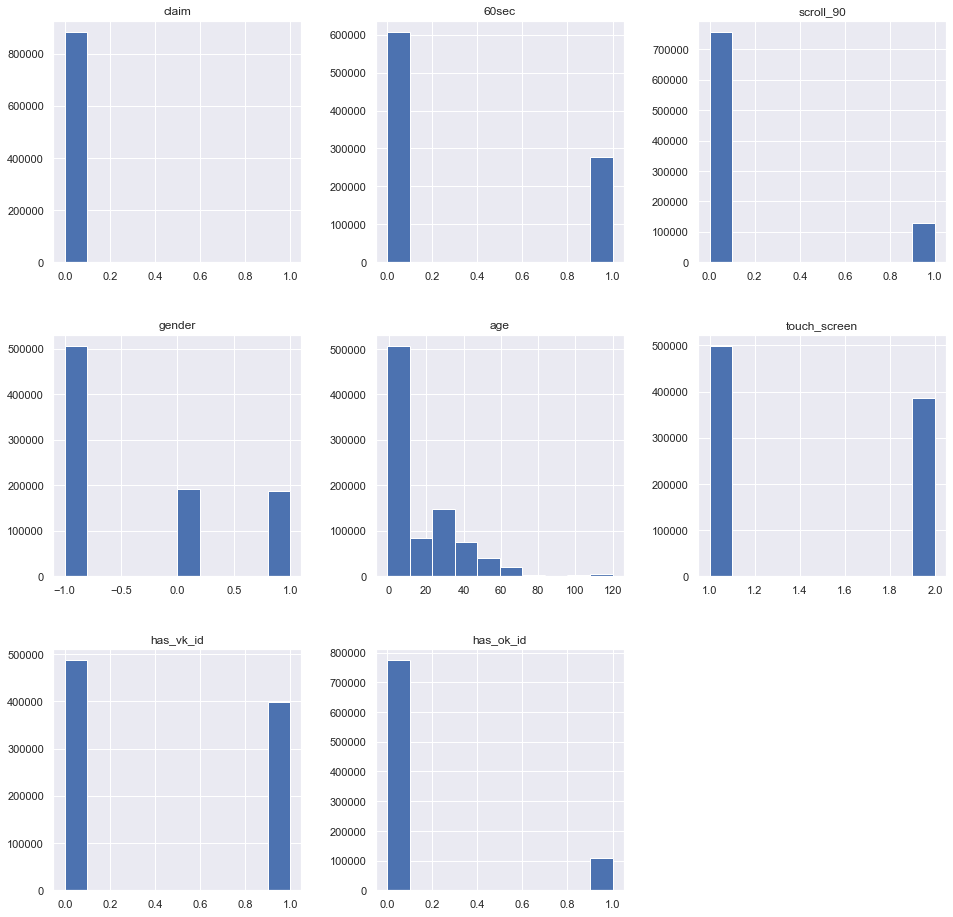

In [8]:
gb_data.hist(figsize=(16,16));

In [9]:
bool_features = ['has_vk_id', 'has_ok_id', '60sec', 'scroll_90']  # бинарные признаки
num_features = list(set(gb_data.select_dtypes(exclude='object').columns) - set(bool_features))  # числовые признаки
obj_features = list(gb_data.select_dtypes(include='object').columns)  # категориальные признаки
num_features, obj_features

(['claim', 'touch_screen', 'gender', 'age'],
 ['session_id', 'hit_date', 'referer_url', 'url', 'utm_source', 'utm_medium'])

## Заполнение пропусков

In [10]:
cols_with_missing = [col for col in gb_data.columns if gb_data[col].isnull().any()]
for col in cols_with_missing:
    gb_data[col + '_undef'] = gb_data[col].isnull()
imputer = SimpleImputer(strategy="constant", fill_value="UNKNOWN")
columns = gb_data.columns.copy()
gb_data[obj_features] = pd.DataFrame(imputer.fit_transform(gb_data[obj_features]))
gb_data.columns = columns
# gb_data = gb_data.drop(cols_with_missing, axis=1)
gb_data.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id,referer_url_undef,utm_source_undef,utm_medium_undef
0,4358a11f0d16be6e,0,0,1,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,UNKNOWN,UNKNOWN,0,39,1,1,0,False,True,True
1,133509b7ff9a586c,0,0,0,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,-1,2,0,0,False,False,False
2,8b23cd36f2b08dcd,0,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,UNKNOWN,UNKNOWN,1,49,1,1,1,False,True,True
3,50de4c060fd128f3,0,1,1,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,UNKNOWN,UNKNOWN,-1,-1,1,1,0,False,True,True
4,c2ca3cc9a67c749b,0,0,0,2021-12-01,UNKNOWN,https://gb.ru/login,UNKNOWN,UNKNOWN,0,23,2,1,0,True,True,True


## Преобразование категориальных признаков

In [11]:
ordinal = OrdinalEncoder()
gb_data[['utm_source', 'utm_medium']] = ordinal.fit_transform(gb_data[['utm_source', 'utm_medium']])
gb_data.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id,referer_url_undef,utm_source_undef,utm_medium_undef
0,4358a11f0d16be6e,0,0,1,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,8.0,2.0,0,39,1,1,0,False,True,True
1,133509b7ff9a586c,0,0,0,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,58.0,17.0,-1,-1,2,0,0,False,False,False
2,8b23cd36f2b08dcd,0,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,8.0,2.0,1,49,1,1,1,False,True,True
3,50de4c060fd128f3,0,1,1,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,8.0,2.0,-1,-1,1,1,0,False,True,True
4,c2ca3cc9a67c749b,0,0,0,2021-12-01,UNKNOWN,https://gb.ru/login,8.0,2.0,0,23,2,1,0,True,True,True


## Проектирование новых признаков

In [12]:
gb_data['gender_M'] = (gb_data['gender'] == 0).astype(int)
gb_data['gender_F'] = (gb_data['gender'] == 1).astype(int)
gb_data['gender_0'] = (gb_data['gender'] == -1).astype(int)
gb_data.drop('gender', axis=1, inplace=True)

In [13]:
gb_data['age_child'] = ((0 <= gb_data['age']) & (gb_data['age'] < 13)).astype(int)
gb_data['age_teen'] = ((13 <= gb_data['age']) & (gb_data['age'] < 20)).astype(int)
gb_data['age_youth'] = ((20 <= gb_data['age']) & (gb_data['age'] < 35)).astype(int)
gb_data['age_middle'] = ((35 <= gb_data['age']) & (gb_data['age'] < 60)).astype(int)
gb_data['age_old'] = ((60 <= gb_data['age']) & (gb_data['age'] < 80)).astype(int)
gb_data['age_antique'] = ((80 <= gb_data['age']) & (gb_data['age'] < 150)).astype(int)
gb_data['age_unknown'] = (gb_data['age'] < 0).astype(int)
gb_data.drop('age', axis=1, inplace=True)

In [14]:
gb_data['url_len'] = gb_data['url'].str.len()
# gb_data.drop('url', axis=1, inplace=True)

In [15]:
# gb_data[~gb_data.fillna('UNKNOWN')['referer_url'].str.contains('gb')]['referer_url'].unique()
# gb_data['utm_medium'].unique()

## Отбор признаков

In [16]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   session_id         884407 non-null  object 
 1   claim              884407 non-null  int64  
 2   60sec              884407 non-null  int64  
 3   scroll_90          884407 non-null  int64  
 4   hit_date           884407 non-null  object 
 5   referer_url        884407 non-null  object 
 6   url                884407 non-null  object 
 7   utm_source         884407 non-null  float64
 8   utm_medium         884407 non-null  float64
 9   touch_screen       884407 non-null  int64  
 10  has_vk_id          884407 non-null  int64  
 11  has_ok_id          884407 non-null  int64  
 12  referer_url_undef  884407 non-null  bool   
 13  utm_source_undef   884407 non-null  bool   
 14  utm_medium_undef   884407 non-null  bool   
 15  gender_M           884407 non-null  int32  
 16  ge

In [17]:
gb_data.drop(gb_data.select_dtypes(include='object').columns, axis=1, inplace=True)
gb_data.head()

,claim,60sec,scroll_90,utm_source,utm_medium,touch_screen,has_vk_id,has_ok_id,referer_url_undef,utm_source_undef,...,gender_F,gender_0,age_child,age_teen,age_youth,age_middle,age_old,age_antique,age_unknown,url_len
0,0,0,1,8.0,2.0,1,1,0,False,True,...,0,0,0,0,0,1,0,0,0,28
1,0,0,0,58.0,17.0,2,0,0,False,False,...,0,1,0,0,0,0,0,0,1,33
2,0,0,0,8.0,2.0,1,1,1,False,True,...,1,0,0,0,0,1,0,0,0,38
3,0,1,1,8.0,2.0,1,1,0,False,True,...,0,1,0,0,0,0,0,0,1,18
4,0,0,0,8.0,2.0,2,1,0,True,True,...,0,0,0,0,1,0,0,0,0,19


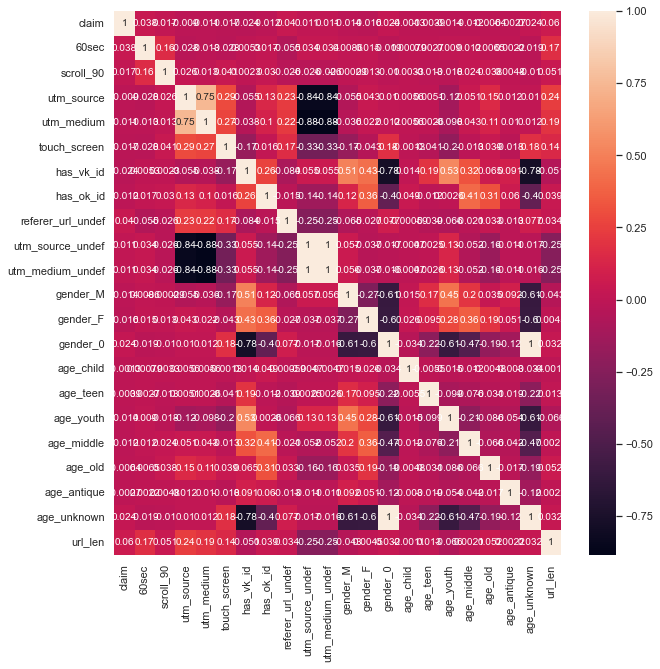

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(gb_data.corr(), annot=True);

In [19]:
claim_0_rate = sum(gb_data['claim'] == 0) / len(gb_data)
claim_1_rate = sum(gb_data['claim'] == 1) / len(gb_data)
print(claim_0_rate, claim_1_rate)

0.9979285555179912 0.002071444482008849


In [20]:
TARGET = 'claim'
X = gb_data.drop(TARGET, axis=1)
y = gb_data[TARGET]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [22]:
mod_cols = ['touch_screen']  # 'url_len'
scaler = MinMaxScaler().fit(X_train[mod_cols])
X_train[mod_cols] = scaler.transform(X_train[mod_cols])
X_test[mod_cols] = scaler.transform(X_test[mod_cols])

In [23]:
pd.DataFrame(data=X_train, columns=X.select_dtypes(exclude='object').columns).describe()

,60sec,scroll_90,utm_source,utm_medium,touch_screen,has_vk_id,has_ok_id,gender_M,gender_F,gender_0,age_child,age_teen,age_youth,age_middle,age_old,age_antique,age_unknown,url_len
count,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000,663305.000000
mean,0.313230,0.144244,30.914243,6.869056,0.436354,0.449309,0.124187,0.216309,0.212106,0.571585,0.000858,0.034078,0.216576,0.140103,0.026276,0.010525,0.571585,27.170201
std,0.463807,0.351338,43.882496,8.911910,0.495933,0.497424,0.329795,0.411728,0.408800,0.494849,0.029276,0.181429,0.411912,0.347094,0.159955,0.102048,0.494849,11.011777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,0.000000,0.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
50%,0.000000,0.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,23.000000
75%,1.000000,0.000000,39.000000,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,33.000000
max,1.000000,1.000000,183.000000,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,621.000000


In [24]:
# model = LogisticRegression(random_state=42, class_weight='balanced')
# model = LinearSVC(random_state=42, class_weight='balanced')
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# model = ComplementNB()
# model = SVC(random_state=42, max_iter=2000, gamma='auto', class_weight='balanced')
# model = SGDClassifier()

# model = xgb.XGBClassifier(random_state=42)
# model = lgbm.LGBMClassifier(random_state=42, class_weight='balanced')
# model = catb.CatBoostClassifier(silent=True, random_state=42, auto_class_weights='Balanced')

sample_weights = None  # compute_sample_weight(class_weight='balanced', y=y_train)
model.fit(X_train, y_train, sample_weight=sample_weights)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [25]:
y_true = y_test
y_pred = model.predict(X_test)

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
F1 = f1_score(y_true, y_pred)

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
print()
print(f"{recall = }")
print(f"{precision = }")
print(f"{balanced_accuracy = }")
print(f"{F1 = }")
print(classification_report(y_true, y_pred))

Confusion matrix:
[[208004  12646]
 [   126    326]]

recall = 0.7212389380530974
precision = 0.02513105149552883
balanced_accuracy = 0.8319632261078993
F1 = 0.04856972586412396
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    220650
           1       0.03      0.72      0.05       452

    accuracy                           0.94    221102
   macro avg       0.51      0.83      0.51    221102
weighted avg       1.00      0.94      0.97    221102



In [26]:
y_prob = model.predict_proba(X_test)
print(f"ROC AUC = {roc_auc_score(y_true, y_prob[:, 1])}")

ROC AUC = 0.8508881793333855


In [27]:
balanced_accuracy_score(y_true, y_pred)

0.8319632261078993

In [28]:
model.score(X, y)

0.944774295092644

In [27]:
pipe = Pipeline(
    steps=[('preprocessing', MinMaxScaler()), ('classifier', LogisticRegression())]
)

param_grid = [
    {'classifier': [LogisticRegression(random_state=42, class_weight='balanced')]},
    {'classifier': [RidgeClassifier(random_state=42, class_weight='balanced')]},
    {'classifier': [DecisionTreeClassifier(random_state=42, class_weight='balanced')]},
    {'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')]},
    {'classifier': [LinearSVC(random_state=42, class_weight='balanced')]},
    {'classifier': [ComplementNB()]},
    {'classifier': [xgb.XGBClassifier(random_state=42)]},
    {'classifier': [lgbm.LGBMClassifier(random_state=42, class_weight='balanced')]},
    {'classifier': [catb.CatBoostClassifier(silent=True, random_state=42, auto_class_weights='Balanced')]}
]

grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
# print(cross_val_score(estimator=grid.estimator_, X=X, y=y, cv=StratifiedKFold()))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params:
{'classifier': RandomForestClassifier(class_weight='balanced', random_state=42)}

Best cross-validation score: 0.03
Test-set score: 0.03


In [28]:
def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = accuracy_score(y_test, pred)
    # print(f"accuracy:   {score:.3}")
    print(classification_report(y_test, pred))

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [29]:
results = []
for clf, name in (
    (LogisticRegression(random_state=42, class_weight='balanced'), "Logistic Regression"),
    (RidgeClassifier(random_state=42, class_weight='balanced'), "Ridge Classifier"),
    #(KNeighborsClassifier(n_jobs=-1, n_neighbors=5), "kNN"),
    (DecisionTreeClassifier(random_state=42, class_weight='balanced'), "Decision Tree"),
    (RandomForestClassifier(random_state=42, class_weight='balanced'), "Random Forest"),
    (LinearSVC(random_state=42, class_weight='balanced'), "Linear SVC"),
    (SGDClassifier(random_state=42, class_weight='balanced', loss="log", alpha=1e-4, n_iter_no_change=3, early_stopping=True), "log-loss SGD",),
    (NearestCentroid(), "NearestCentroid"),
    (ComplementNB(), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(class_weight='balanced', random_state=42)
train time: 5.87s
test time:  0.018s
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    220650
           1       0.01      0.85      0.02       452

    accuracy                           0.85    221102
   macro avg       0.51      0.85      0.47    221102
weighted avg       1.00      0.85      0.92    221102

dimensionality: 16
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(class_weight='balanced', random_state=42)
train time: 0.353s
test time:  0.016s
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    220650
           1       0.01      0.86      0.02       452

    accuracy                           0.84    221102
   mac